# Gaussian Mixture based on Time separation

## Define the time zones and $n$ first

Just add the max floor value of each time zone, it must end with 23, e.g. [1,4,23] would me the following time zones: [0,1],[2,4],[4,23]

In [84]:
time_zones = [5,9,14,19,23]
n = 20

## ========================

In [85]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

%matplotlib inline

In [86]:
def reconstruct_sample(n, mean_x, mean_y, scale, w, size=1500):
    reconstruction_sample = []
    for i in range(n):
        xs = np.random.normal(loc=mean_x.iloc[i], scale=scale.iloc[i], size=int(size*w.iloc[i]))
        ys = np.random.normal(loc=mean_y.iloc[i], scale=scale.iloc[i], size=int(size*w.iloc[i]))
        reconstruction_sample.extend(np.vstack((xs,ys)).T)

    reconstruction_sample = np.array(reconstruction_sample)
    return reconstruction_sample

In [87]:
df = pd.read_csv('encuesta_corregida.csv')

df = df.loc[(df.MUNICIPIO_DESTINO == 'BOGOTA-DC 11001') & (df.MUNICIPIO_ORIGEN == 'BOGOTA-DC 11001') & (df.MEDIO_PREDOMINANTE == 'TAXI')]
df.loc[df.HORA_FIN.str.contains("24:00:00"), "HORA_FIN"] = "00:00:00"
df.loc[:,'HORA_FIN'] = pd.to_datetime(df.HORA_FIN, format="%H:%M:%S")
df.loc[:,'HORA_INICIO'] = pd.to_datetime(df.HORA_INICIO, format="%H:%M:%S")

df = df.loc[(df.MUNICIPIO_DESTINO == 'BOGOTA-DC 11001') & (df.MUNICIPIO_ORIGEN == 'BOGOTA-DC 11001') & (df.MEDIO_PREDOMINANTE == 'TAXI')]

In [88]:
to_csv = pd.DataFrame(columns=['max_hour','w_cumulative', 'w','std','mean_x','mean_y'])

In [92]:
last_max_time = -1

for max_time in time_zones:
    
    df_temp = df.loc[(df.HORA_INICIO.dt.hour > last_max_time) & (df.HORA_INICIO.dt.hour <= max_time)]
    to_csv_temp = pd.DataFrame(index=range(n), columns=['max_hour','w','w_cumulative','std','mean_x','mean_y'])

    gmb = GaussianMixture(n, max_iter=10000, covariance_type="spherical")
    gmb.fit(df_temp.loc[:,['x_coord_org','y_coord_org']].values.reshape(-1, 2));
    
    cumulative_w = []
    w = 0
    for weight in gmb.weights_:
        w += weight
        cumulative_w.append(w)
        
    to_csv_temp.loc[:,'max_hour'] = max_time
    to_csv_temp.loc[:,'w'] = gmb.weights_
    to_csv_temp.loc[:,'w_cumulative'] = cumulative_w
    to_csv_temp.loc[:,'std'] = gmb.covariances_ ** 0.5
    to_csv_temp.loc[:,['mean_x', 'mean_y']] = gmb.means_
    
    to_csv = pd.concat([to_csv,to_csv_temp], ignore_index=True)
    
    last_max_time = max_time

## Generating plots

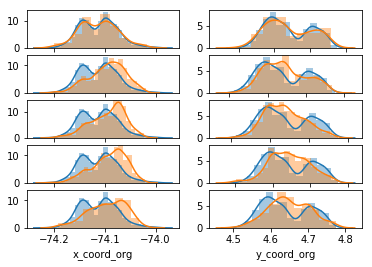

In [90]:
last_max_time = -1

fig, axs = plt.subplots(len(time_zones),2)

for i, max_time in enumerate(time_zones):
    reconstructed = reconstruct_sample(n, to_csv.loc[to_csv.max_hour == max_time,'mean_x'], to_csv.loc[to_csv.max_hour == max_time, 'mean_y'], to_csv.loc[to_csv.max_hour == max_time,'std'], to_csv.loc[to_csv.max_hour == max_time,'w'], size=1500)
    
    df_temp = df.loc[(df.HORA_INICIO.dt.hour > last_max_time) & (df.HORA_INICIO.dt.hour <= max_time)]
    
    sns.distplot(reconstruct.T[0],ax=axs[i,0])
    sns.distplot(df_temp.x_coord_org, ax=axs[i,0])
    
    sns.distplot(reconstruct.T[1],ax=axs[i,1])
    sns.distplot(df_temp.y_coord_org, ax=axs[i,1])
    
    last_max_time = max_time

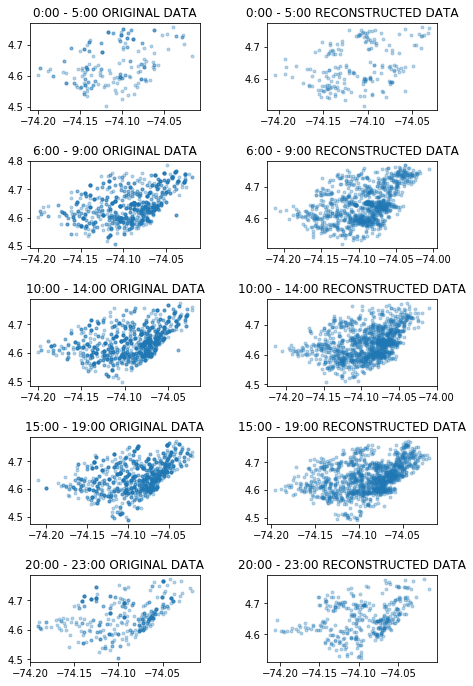

In [123]:
last_max_time = -1

fig, axs = plt.subplots(len(time_zones),2)

fig.set_figheight(10)
fig.set_figwidth(7)
plt.tight_layout(pad=3)

for i, max_time in enumerate(time_zones):
    df_temp = df.loc[(df.HORA_INICIO.dt.hour > last_max_time) & (df.HORA_INICIO.dt.hour <= max_time)]
    
    reconstructed = reconstruct_sample(n, to_csv.loc[to_csv.max_hour == max_time,'mean_x'], to_csv.loc[to_csv.max_hour == max_time, 'mean_y'], to_csv.loc[to_csv.max_hour == max_time,'std'], to_csv.loc[to_csv.max_hour == max_time,'w'], size=df_temp.shape[0])
    
    axs[i,0].plot(df_temp.x_coord_org, df_temp.y_coord_org, '.', alpha=.3)
    axs[i,1].plot(reconstructed.T[0], reconstructed.T[1],'.', alpha=.3)
    title = "" + str(last_max_time+1) + ":00 - " + str(max_time) + ":00"
    axs[i,0].set_title(title+ " ORIGINAL DATA") 
    axs[i,1].set_title(title+ " RECONSTRUCTED DATA") 

    last_max_time = max_time

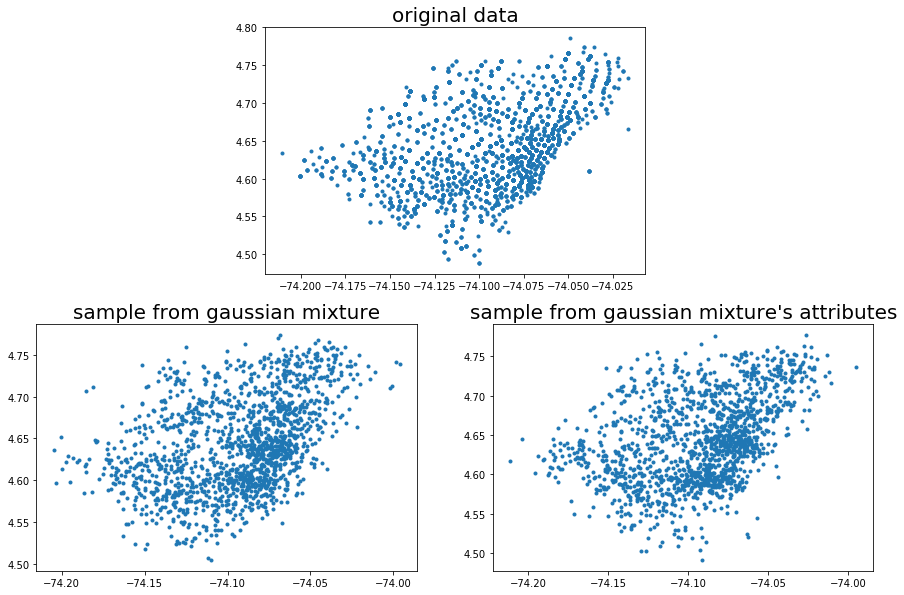

In [11]:
plt.close()



plt.figure(figsize=[15,10])

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, 1:3], )
ax2 = plt.subplot(gs[1, :2])
ax3 = plt.subplot(gs[1, 2:])

#fig, axs = plt.subplots(2,2)
ax1.plot(df.x_coord_org, df.y_coord_org, '.')
ax1.set_title("original data", fontsize=20)

sample = gmb.sample(size)[0].T
ax2.plot(sample[0], sample[1],'.')
ax2.set_title("sample from gaussian mixture", fontsize=20)

ax3.plot(reconstruction_sample.T[0], reconstruction_sample.T[1],'.')
ax3.set_title("sample from gaussian mixture's attributes", fontsize=20)

#fig.set_figwidth(40)

In [ ]:
to_csv.to_csv('netlogo_reader/org.csv')